# initialize the workspace

## import relevant packages

In [8]:
# import packages
import numpy as np
import cv2
from skimage.measure import label, regionprops
from skimage import img_as_ubyte
import tifffile
import matplotlib.pyplot as plt

## import the test image
+ display it

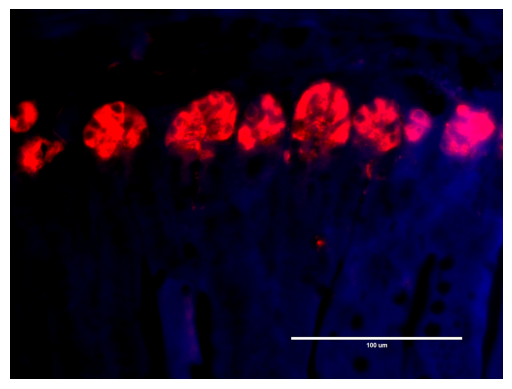

In [9]:
# class
class BlobDetector:
    def __init__(self, image_path):
        self.image_path = image_path
        self.raw_image = tifffile.imread(image_path)
        self.current_image = self.raw_image.copy()
        self.bar_mask = None
        self.binary_mask = None
        self.cleaned_mask = None
        self.blob_props = None
    def display(self, img=None):
        if img is None:
            img = self.current_image
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
# init class
image_path = "G2EB-RFP 40x-4.tif"
detector = BlobDetector(image_path)
detector.display()


# image preparation and processing

## prep class

In [10]:
class image_prep:
    class inconvenient_object_remover:
        def __init__(self, raw_image):
            self.raw_image = raw_image
        def remove_scale_bar(self, intensity_threshold=240, min_area=500, aspect_ratio_thresh=4.0):
            img = self.raw_image
            if img.ndim == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            else:
                gray = img.copy()
    
            _, binary = cv2.threshold(gray, intensity_threshold, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
            mask = np.ones_like(gray, dtype=np.uint8)
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                area = cv2.contourArea(cnt)
                aspect_ratio = max(w / h, h / w)
                if area > min_area and aspect_ratio > aspect_ratio_thresh:
                    cv2.rectangle(mask, (x, y), (x + w, y + h), 0, -1)
    
            self.bar_mask = mask
            if img.ndim == 3:
                self.current_image = cv2.merge([
                    cv2.bitwise_and(img[:, :, c], img[:, :, c], mask=mask)
                    for c in range(img.shape[2])
                ])
            else:
                self.current_image = cv2.bitwise_and(img, img, mask=mask)
            return self.current_image
    class select_image_channels:
        @staticmethod
        def red(img):
            
            if img.ndim == 3:
                current_image = img[:, :, 0]
            else:
                current_image = img.copy()
            return current_image
        @staticmethod
        def red_chromaticity(img):
            if img.ndim != 3:
                raise ValueError("Red chromaticity requires an RGB image.")
            R = img[:, :, 0].astype(float)
            G = img[:, :, 1].astype(float)
            B = img[:, :, 2].astype(float)
    
            epsilon = 1e-8  # Avoid division by zero
            sum_rgb = R + G + B + epsilon
            red_chroma = R / sum_rgb
    
            return (red_chroma * 255).astype(np.uint8)  # Scale back to 0-255 for image-like display
    class enhance_contrast:
        @staticmethod
        def CLAHE(img, clip_limit=2.0, tile_grid_size=(8,8)):
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
            img_8bit = img_as_ubyte(img / img.max())  # Normalize to 8-bit
            return clahe.apply(img_8bit)
        @staticmethod
        def enhance_nonblack(img, value=255):
            """
            Set all non-zero pixels in a grayscale image to a fixed value.
            Black (0) pixels remain black.

            Parameters:
            - img: Grayscale image as numpy array.
            - value: Brightness value to set (default 255).

            Returns:
            - Enhanced image.
            """
            # Ensure image is a numpy array
            img = np.asarray(img)

            # Create output array
            enhanced = np.zeros_like(img, dtype=np.uint8)

            # Set non-zero pixels to 'value'
            enhanced[img > 0] = value

            return enhanced
    class masker:            
        def __init__(self, image):
            self.current_image = image
        def otsu(self):
            _, binary = cv2.threshold(self.current_image, 20, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            self.binary_mask = binary
            return self
        def morph_cleanup(self, kernel_size=5):
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
            cleaned = cv2.morphologyEx(self.binary_mask, cv2.MORPH_OPEN, kernel)
            cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
            self.cleaned_mask = cleaned
            return self
        
            
    

## remove scale bar

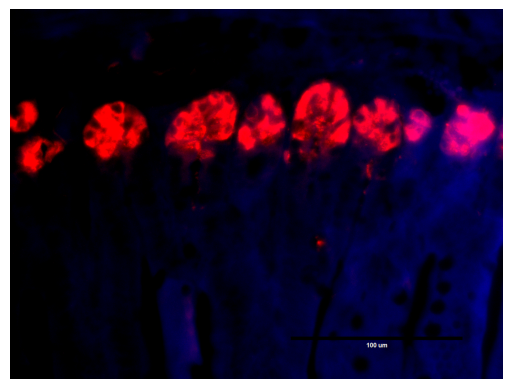

In [11]:
inconvenient_object_remover = image_prep.inconvenient_object_remover
detector.current_image = inconvenient_object_remover(detector.current_image).remove_scale_bar()
detector.display()

## select red chanel
this is bc the lysozyme stains fit nicely within the red channel, also removes the blue background

In [12]:
detector.red_chr_image = image_prep.select_image_channels.red_chromaticity(detector.current_image)
detector.red_image = image_prep.select_image_channels.red(detector.current_image)

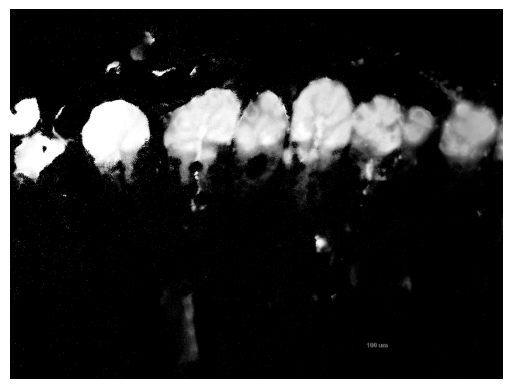

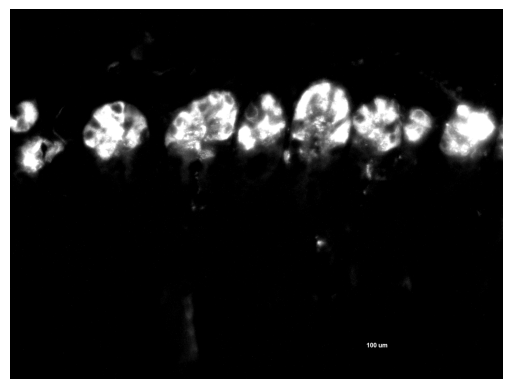

In [13]:
detector.display(img=detector.red_chr_image)
detector.display(img=detector.red_image)

## apply CLAHE


### code

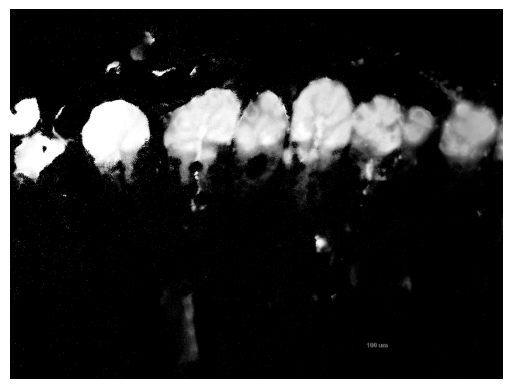

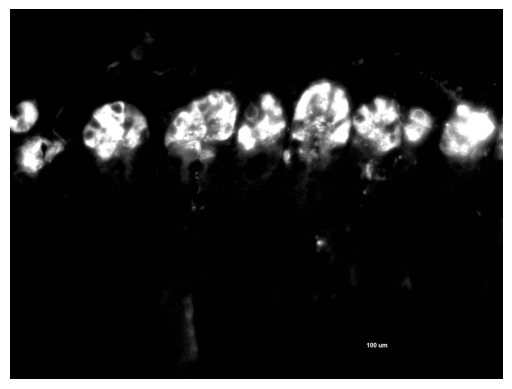

In [14]:
detector.red_chr_image_enhanced = image_prep.enhance_contrast.enhance_nonblack(detector.red_chr_image)
detector.red_image = image_prep.enhance_contrast.CLAHE(detector.red_image)
detector.display(detector.red_chr_image)
detector.display(img=detector.red_image)
    

## binary mask
the goal of this is to create a binary mask that cleanly captures the boundries of the stained lysozyme regions

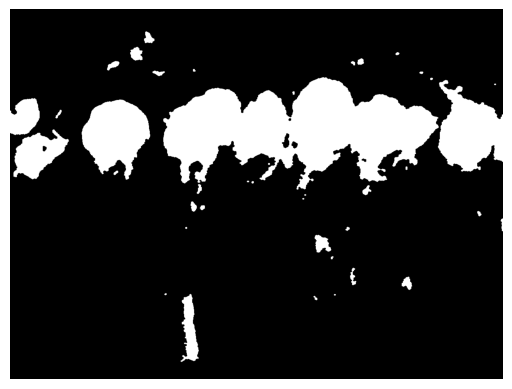

In [15]:
detector.chr_binary_mask = image_prep.masker(detector.red_chr_image_enhanced).otsu().morph_cleanup().cleaned_mask
plt.imshow(detector.chr_binary_mask, cmap='gray')
plt.axis('off')
plt.show()



# extract blobs
following the image processing creating a representative binary map, we will use said binary map to identify broader boundries of the things

## blob handler class

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, segmentation, color, measure
from scipy import ndimage as ndi

class BlobDetector:
    class region_based_segmentation:
        def __init__(self, image, low_thresh=10, high_thresh=150):
            self.image = image
            self.low_thresh = low_thresh
            self.high_thresh = high_thresh

            self.elevation_map = None
            self.markers = None
            self.segmentation = None
            self.labeled = None
            self.label_overlay = None

        def detect_blobs(self):
            # 1️⃣ Compute elevation map
            self.elevation_map = filters.sobel(self.image)

            # 2️⃣ Generate markers
            self.markers = np.zeros_like(self.image, dtype=np.uint8)
            self.markers[self.image < self.low_thresh] = 1
            self.markers[self.image > self.high_thresh] = 2

            # 3️⃣ Watershed segmentation
            self.segmentation = segmentation.watershed(self.elevation_map, self.markers)
            self.segmentation = ndi.binary_fill_holes(self.segmentation - 1)

            # 4️⃣ Label blobs
            self.labeled, _ = ndi.label(self.segmentation)

            # 5️⃣ Create label overlay
            self.label_overlay = color.label2rgb(self.labeled, image=self.image, bg_label=0)
            return self
        def show_results(self):
            if self.elevation_map is None:
                raise RuntimeError("Run detect_blobs() first!")

            fig, axes = plt.subplots(2, 3, figsize=(12, 6))
            
            # Original image
            axes[0, 0].imshow(self.image, cmap='gray')
            axes[0, 0].set_title('Original Image')
            axes[0, 0].axis('off')

            # Elevation map
            axes[0, 1].imshow(self.elevation_map, cmap='gray')
            axes[0, 1].set_title('Elevation Map')
            axes[0, 1].axis('off')

            # Markers
            axes[0, 2].imshow(self.markers, cmap='nipy_spectral')
            axes[0, 2].set_title('Markers')
            axes[0, 2].axis('off')

            # Segmentation
            axes[1, 0].imshow(self.segmentation, cmap='gray')
            axes[1, 0].set_title('Segmentation Mask')
            axes[1, 0].axis('off')

            # Labeled blobs
            axes[1, 1].imshow(self.label_overlay)
            axes[1, 1].set_title('Label Overlay')
            axes[1, 1].axis('off')

            # Segmentation overlay on original
            axes[1, 2].imshow(self.image, cmap='gray')
            axes[1, 2].contour(self.segmentation, [0.5], linewidths=1.2, colors='y')
            axes[1, 2].set_title('Segmentation Overlay')
            axes[1, 2].axis('off')

            fig.tight_layout()
            plt.show()
            

        

## implement blob detection using region-based segmentation

## water implementation

### first identify the blobs

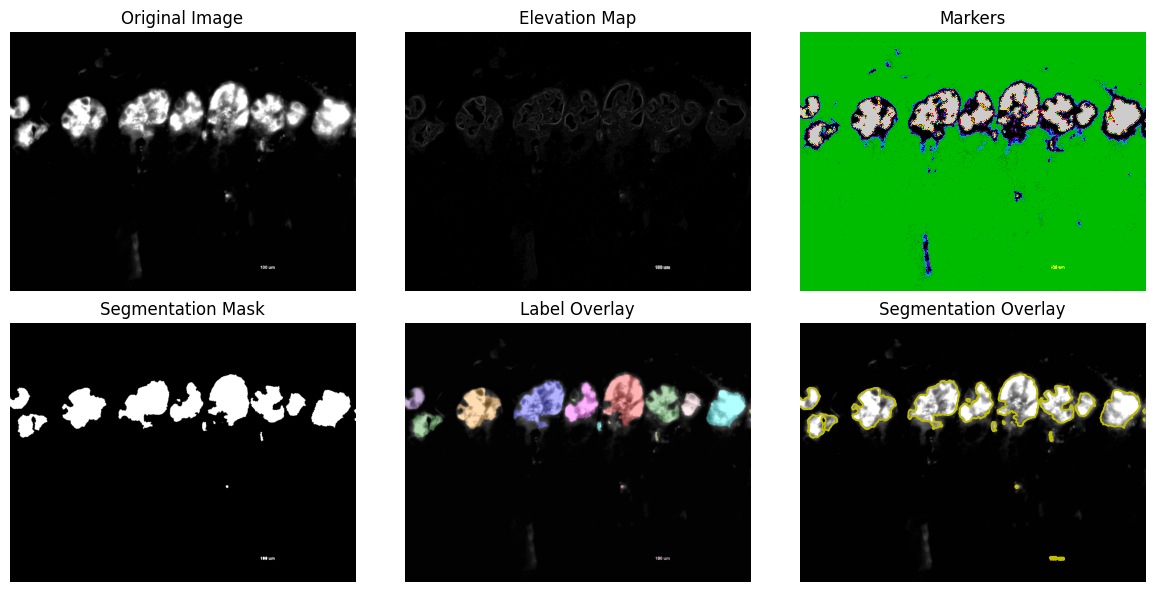

In [17]:
blob_detector = BlobDetector.region_based_segmentation(detector.red_image, low_thresh=30, high_thresh=150)
blob_detector.detect_blobs().show_results()

## second define the real boundries of each blob

🧠 Swallowing Logic: Rule Definition
For each pair of adjacent regions in the expanded mask:

If Region A and Region B touch:

And Area(B) < (1/20) × Area(A) (based on original pre-expansion area from tight labels):

Region A absorbs Region B (relabel B’s pixels as A).

If neither is larger by that margin, leave both unchanged.

In [53]:
from skimage import measure
from skimage.segmentation import flood, watershed
from skimage.morphology import dilation, square
from skimage.color import label2rgb
import numpy as np
import matplotlib.pyplot as plt
import os

class CompetitiveFlooding:
    def __init__(self, tight_labels, loose_mask, red_image, terrain=None, debug = False):
        
        self.tight_labels = tight_labels
        self.loose_mask = loose_mask
        self.red_image = red_image
        self.terrain = (terrain if terrain is not None
                        else np.ones_like(loose_mask, dtype=np.uint8))

        # Containers populated by the pipeline
        self.original_areas: dict[int, int] = {}
        self.loose_boundaries: dict[int, np.ndarray] = {}
        self.expanded_labels: np.ndarray | None = None
        self.swallowed_labels: np.ndarray | None = None
        self.adjacency: dict[int, list[int]] = {}
        self.border_lengths: dict[tuple[int, int], int] = {}
        self.swallow_plan: dict[int, int] = {}
        self.border_labels: set[int] = set()
        self.debug = debug

        self._compute_original_areas()
    # ------------------------------------------------------------------
    # Internal helpers
    # ------------------------------------------------------------------
    def _compute_original_areas(self):
        for region in measure.regionprops(self.tight_labels):
            self.original_areas[region.label] = region.area

    def _get_border_labels(self, label_image):
        mask = np.zeros_like(label_image, dtype=bool)
        mask[0, :] = mask[-1, :] = mask[:, 0] = mask[:, -1] = True
        labels = np.unique(label_image[mask])
        return set(labels[labels != 0])
    
    # ------------------------------------------------------------------
    # Public pipeline steps (each returns self for chaining)
    # ------------------------------------------------------------------

    def compute_loose_boundaries(self):
        """Flood fill around each centroid on the loose mask."""
        for region in measure.regionprops(self.tight_labels):
            centroid = tuple(map(int, region.centroid))
            self.loose_boundaries[region.label] = flood(
                self.loose_mask, seed_point=centroid)
        if self.debug: print("Loose boundaries computed for tight labels.")
        return self

    def run_watershed(self):
        """Expand tight blobs into loose regions via watershed."""
        self.expanded_labels = watershed(
            self.terrain,
            markers=self.tight_labels.copy(),
            mask=self.loose_mask)
        self.swallowed_labels = self.expanded_labels.copy()
        self.border_labels = self._get_border_labels(self.expanded_labels)
        if self.debug:
            print(f"Watershed run complete. "
                  f"Expanded labels shape: {self.expanded_labels.shape}, "
                  f"Border labels: {self.border_labels}")
        return self

    def compute_adjacency(self, size_factor: int = 20):
        """Build adjacency of small blobs to large neighbors (≥ size_factor ×)."""
        if self.expanded_labels is None:
            raise RuntimeError("run_watershed() first")

        self.adjacency.clear()
        self.border_lengths.clear()
        for lbl in np.unique(self.expanded_labels):
            if lbl == 0:
                continue
            area_lbl = self.original_areas.get(lbl, 0)
            mask = self.expanded_labels == lbl
            dil = dilation(mask, square(3))
            neighbors = np.unique(self.expanded_labels[dil])
            neighbors = [n for n in neighbors if n not in (0, lbl)]

            eligible = []
            for n in neighbors:
                area_n = self.original_areas.get(n, 0)
                if area_n >= area_lbl * size_factor:
                    eligible.append(n)
                    shared = np.logical_and(dil, self.expanded_labels == n)
                    self.border_lengths[(lbl, n)] = int(np.sum(shared))
            if eligible:
                self.adjacency[lbl] = eligible
        if self.debug:
            print(f"Adjacency computed. "
                  f"Found {len(self.adjacency)} small blobs with neighbors.")
            for lbl, neighbors in self.adjacency.items():
                print(f"Label {lbl} has neighbors: {neighbors} "
                      f"with border lengths: {[self.border_lengths.get((lbl, n), 0) for n in neighbors]}")
        return self

    def plan_swallow(self):
        """Select best large neighbor for each small blob (largest shared border)."""
        self.swallow_plan.clear()
        for lbl, neighbors in self.adjacency.items():
            if lbl in self.border_labels:
                continue  # do not swallow border‑touching blobs
            best = max(neighbors, key=lambda n: (
                self.border_lengths.get((lbl, n), 0),
                self.original_areas.get(n, 0)))
            self.swallow_plan[lbl] = best
        if self.debug:
            print(f"Label {lbl} will be swallowed by {best} "
                    f"with border length {self.border_lengths.get((lbl, best), 0)}")
        return self

    def apply_swallow(self):
        """Relabel small blobs with their chosen large neighbor labels."""
        if self.expanded_labels is None:
            raise RuntimeError("run_watershed() first")
        self.swallowed_labels = self.expanded_labels.copy()
        for small, big in self.swallow_plan.items():
            self.swallowed_labels[self.swallowed_labels == small] = big
        if self.debug:
            print(f"Swallow plan applied. "
                  f"Swallowed labels: {list(self.swallow_plan.keys())} "
                  f"into {list(self.swallow_plan.values())}")
        return self

    def visualize(self, save_dir= None,
                  save_name = "competitive_flooding.png"):
        """Show and optionally save a three‑panel summary figure.

        Returns self so you can keep chaining if you like (e.g., to access
        attributes afterwards without breaking the chain).
        """
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        if self.swallowed_labels is None:
            raise RuntimeError("apply_swallow() first")

        expanded_rgb = label2rgb(self.expanded_labels, image=self.red_image, bg_label=0)
        swallowed_rgb = label2rgb(self.swallowed_labels, image=self.red_image, bg_label=0)

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(self.red_image, cmap="gray")
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(expanded_rgb)
        axes[1].set_title("Expanded Labels")
        axes[1].axis("off")

        axes[2].imshow(swallowed_rgb)
        axes[2].set_title("Swallowed Labels")
        axes[2].axis("off")

        plt.tight_layout()
        if save_dir:
            fig.savefig(os.path.join(save_dir, save_name), bbox_inches="tight", dpi=300)
        plt.show()
        if self.debug:
            print(f"Visualization saved to {os.path.join(save_dir, save_name)}" if save_dir else "Visualization displayed.")
        return self
        


In [55]:

# Provide your arrays:
tight = blob_detector.labeled
loose = detector.chr_binary_mask
red_img = detector.red_chr_image

cf = CompetitiveFlooding(tight_labels=blob_detector.labeled, loose_mask = detector.chr_binary_mask, red_image = detector.red_image, debug=True).compute_loose_boundaries().run_watershed().compute_adjacency(size_factor=20).plan_swallow().apply_swallow().visualize(save_dir="results")


Loose boundaries computed for tight labels.
Watershed run complete. Expanded labels shape: (960, 1280), Border labels: {np.int32(8), np.int32(16), np.int32(13), np.int32(6)}
Adjacency computed. Found 11 small blobs with neighbors.
Label 3 has neighbors: [np.int32(1)] with border lengths: [36]
Label 10 has neighbors: [np.int32(2), np.int32(4)] with border lengths: [35, 84]
Label 11 has neighbors: [np.int32(4), np.int32(10)] with border lengths: [42, 40]
Label 12 has neighbors: [np.int32(4)] with border lengths: [60]
Label 13 has neighbors: [np.int32(8)] with border lengths: [71]
Label 14 has neighbors: [np.int32(1), np.int32(17)] with border lengths: [61, 3]
Label 16 has neighbors: [np.int32(8)] with border lengths: [18]
Label 17 has neighbors: [np.int32(1)] with border lengths: [31]
Label 18 has neighbors: [np.int32(1), np.int32(4)] with border lengths: [11, 67]
Label 19 has neighbors: [np.int32(1)] with border lengths: [88]
Label 20 has neighbors: [np.int32(5)] with border lengths: [8

In [42]:
# diagnostic to check the amount of blobs found
import numpy as np
from skimage import measure

# Assuming `cf` is the CompetitiveFlooding instance you just ran
tight_count      = np.max(blob_detector.labeled)  # Number of tight blobs
expanded_count   = len(np.unique(cf.expanded_labels))  - 1
final_count      = len(np.unique(cf.swallowed_labels)) - 1

print("Tight blobs :", tight_count)
print("Expanded    :", expanded_count)
print("Final blobs :", final_count)

Tight blobs : 26
Expanded    : 21
Final blobs : 12


## extract the results

In [56]:


from skimage import measure

# final_labels = your label image after swallowing
final_labels = swallowed_labels
# Compute region properties
props = measure.regionprops(final_labels)

# Sort by area (descending)
sorted_props = sorted(props, key=lambda r: r.area, reverse=True)

# Get top 5 blobs
top_blobs = sorted_props[:5]

# Get their labels
top_labels = [region.label for region in top_blobs]
print("Top 5 blob labels:", top_labels)

# Dictionary: {label: mask}
blob_masks = {}

for region in top_blobs:
    mask = (final_labels == region.label)
    blob_masks[region.label] = mask
    
    
blob_intensity_data = {}

for label, mask in blob_masks.items():
    intensity_region = detector.red_image * mask
    blob_intensity_data[label] = intensity_region

    # Example: Compute stats
    intensities = detector.red_image[mask]
    mean_intensity = intensities.mean()
    max_intensity = intensities.max()
    min_intensity = intensities.min()
    print(f"Blob {label}: Mean={mean_intensity:.2f}, Max={max_intensity}, Min={min_intensity}")



Top 5 blob labels: [1, 2, 7, 8, 5]
Blob 1: Mean=134.16, Max=255, Min=2
Blob 2: Mean=135.77, Max=255, Min=2
Blob 7: Mean=141.90, Max=255, Min=2
Blob 8: Mean=140.35, Max=255, Min=2
Blob 5: Mean=122.18, Max=255, Min=2
